# San Diego Burrito Analytics: Data characterization

Scott Cole

21 May 2016

This notebook characterizes the collection of reviewers of San Diego burritos including:

1. Metadata
2. How many of each kind of burrito have been reviewed?
3. For each of burrito dimension, what is the distribution of its scores across all samples?

### Default imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style("white")

### Load data

In [2]:
import util
df = util.load_burritos()
N = df.shape[0]

### Brief metadata

In [3]:
print 'Number of burritos:', df.shape[0]
print 'Number of restaurants:', len(df.Location.unique())
print 'Number of reviewers:', len(df.Reviewer.unique())
print 'Number of reviews by Scott:', df.Reviewer.value_counts()['Scott']
print 'Number of reviews by Emily:', df.Reviewer.value_counts()['Emily']

uniqlocidx = df.Location.drop_duplicates().index
print 'Percentage of taco shops with free chips:', np.round(100 - 100*df.Chips[uniqlocidx].isnull().sum()/np.float(len(df.Location.unique())),1)

Number of burritos: 205
Number of restaurants: 52
Number of reviewers: 52
Number of reviews by Scott: 69
Number of reviews by Emily: 36
Percentage of taco shops with free chips: 26.9


In [23]:
# Count of how many burritos each person has eaten
df['Reviewer'].value_counts()

Scott        69
Emily        36
Ricardo      12
Sage          7
Brent         6
Luis          6
Elynn         5
Erin          5
Matteo        4
Richard       3
Marc          3
Bankole       3
Katie         2
Kelsey        2
Hannah        2
Cris          2
Tara          2
Aga           2
Sankha G      1
Torben        1
Mike T        1
Andy          1
Jake          1
Jaeyoung      1
Tom           1
Melissa N     1
Daniel        1
Rob G         1
Melissa G     1
Eli           1
Dan           1
Sandra        1
Leo           1
TJ            1
Ashley G      1
Aaron S       1
Christian     1
Erik          1
Alejandro     1
Rob           1
Sam A         1
Sam H         1
Brad P        1
Brad          1
Devleena      1
Benni         1
Meghan        1
Alex          1
Javier        1
Nicole        1
Tammy         1
Matt          1
Name: Reviewer, dtype: int64

### What types of burritos have been rated?

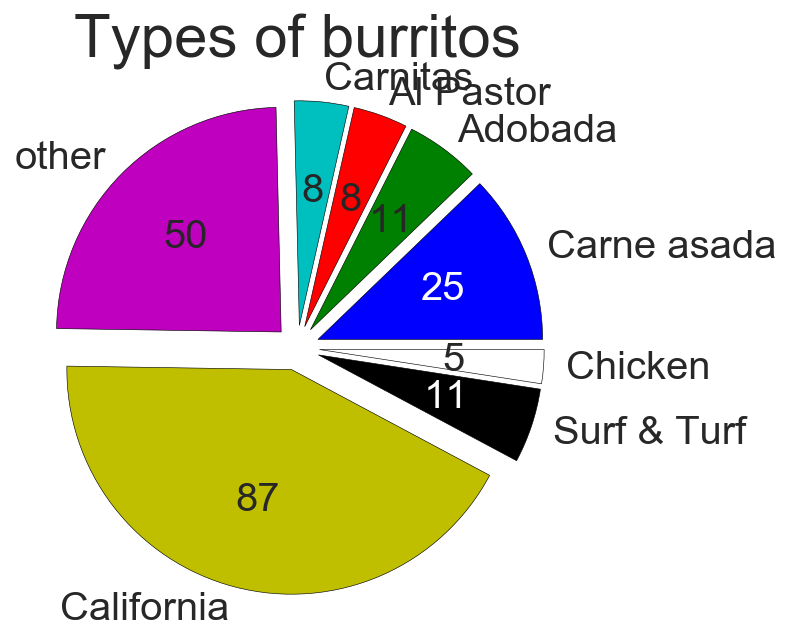

In [4]:
# Number of each type of burrito
def burritotypes(x, types = {'California':'cali', 'Carnitas':'carnita', 'Carne asada':'carne asada',
                             'Chicken':'chicken', 'Surf & Turf':'surf.*turf', 'Adobada':'adobad', 'Al Pastor':'pastor'}):
    import re
    T = len(types)
    Nmatches = {}
    for b in x:
        matched = False
        for t in types.keys():
            re4str = re.compile('.*'+types[t]+'.*', re.IGNORECASE)
            if np.logical_and(re4str.match(b) is not None, matched is False):
                try:
                    Nmatches[t] +=1
                except KeyError:
                    Nmatches[t] = 1
                matched = True
        if matched is False:
            try:
                Nmatches['other'] +=1
            except KeyError:
                Nmatches['other'] = 1
    return Nmatches

typecounts = burritotypes(df.Burrito)

plt.figure(figsize=(6,6))
ax = plt.axes([0.1, 0.1, 0.65, 0.65])

# The slices will be ordered and plotted counter-clockwise.
labels = typecounts.keys()
fracs = typecounts.values()
explode=[.1]*len(typecounts)

patches, texts, autotexts = plt.pie(fracs, explode=explode, labels=labels,
                autopct=lambda(p): '{:.0f}'.format(p * np.sum(fracs) / 100), shadow=False, startangle=0)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

plt.title('Types of burritos',size=30)
for t in texts:
    t.set_size(20)
for t in autotexts:
    t.set_size(20)
autotexts[0].set_color('w')
autotexts[6].set_color('w')

figname = 'burritotypes'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

### Progress in number of burritos rated

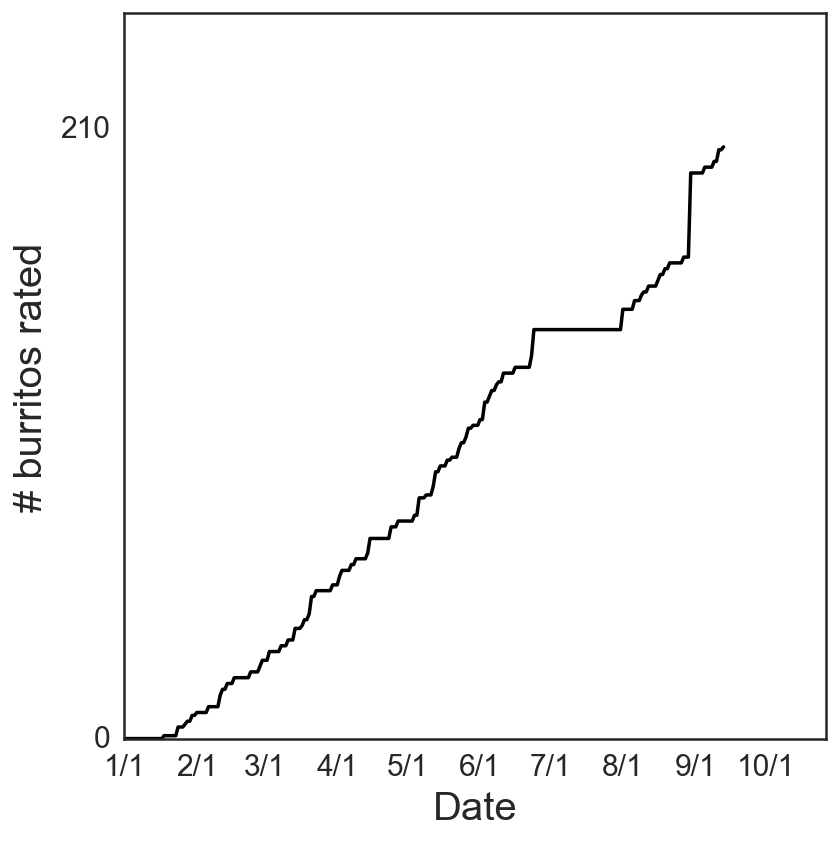

In [5]:
# Time series of ratings
import math

def dates2ts(dates):
    from datetime import datetime
    
    D = len(dates)
    start = datetime.strptime('1/1/2016','%m/%d/%Y')
    ts = np.zeros(D,dtype=int)
    for d in range(D):
        burrdate = datetime.strptime(df.Date[d],'%m/%d/%Y')
        diff = burrdate - start
        ts[d] = diff.days
    return ts

def cumburritos(days):
    from statsmodels.distributions.empirical_distribution import ECDF
    ecdf = ECDF(days)
    t = np.arange(days[-1]+1)
    return t, ecdf(t)*len(days)

def datelabels(startdate = '1/1/2016', M = 10):
    from datetime import datetime
    start = datetime.strptime(startdate,'%m/%d/%Y')
    datestrs = []
    ts = np.zeros(M)
    for m in range(M):
        datestrs.append(str(m+1) + '/1')
        burrdate = datetime.strptime(datestrs[m]+'/2016','%m/%d/%Y')
        diff = burrdate - start
        ts[m] = diff.days
    return datestrs, ts

burrdays = dates2ts(df.Date)
t, burrcdf = cumburritos(burrdays)
datestrs, datets = datelabels()

plt.figure(figsize=(6,6))
plt.plot(t,burrcdf,'k-')
plt.xlabel('Date',size=20)
plt.ylabel('# burritos rated',size=20)
plt.xticks(datets,datestrs,size=15)
plt.yticks((0,int(math.ceil(len(burrdays) / 10.0)) * 10),size=15)
plt.tight_layout()

figname = 'burritoprogress'
plt.savefig('C:/Users/Scott/Google Drive/qwm/burritos/figs/'+figname + '.png')

# Burrito dimension distributions

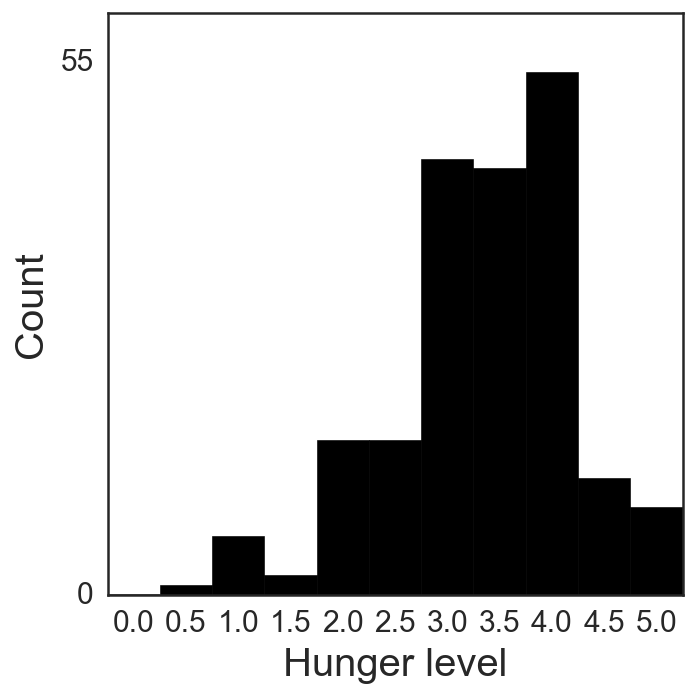

In [6]:
# Distribution of hunger level
plt.figure(figsize=(5,5))
n, _, _ = plt.hist(df.Hunger,np.arange(-.25,5.5,.5),color='k')
plt.xlabel('Hunger level',size=20)
plt.xticks(np.arange(0,5.5,.5),size=15)
plt.xlim((-.25,5.25))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'hungerleveldist'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

6.8992195122


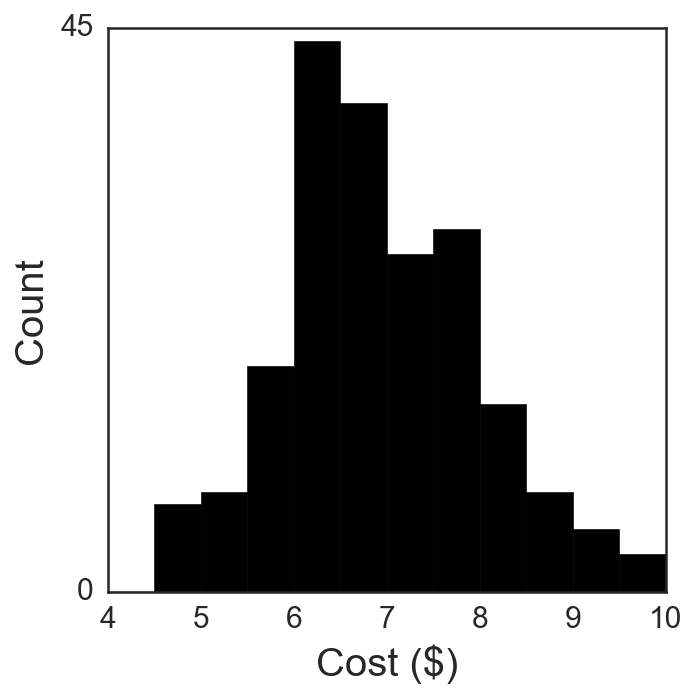

In [7]:
# Average burrito cost
plt.figure(figsize=(5,5))
n, _, _ = plt.hist(df.Cost,np.arange(4,10.25,.5),color='k')
plt.xlabel('Cost ($)',size=20)
plt.xticks(np.arange(4,11,1),size=15)
plt.xlim((4,10))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'costdist'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

print np.mean(df.Cost)

0.785217391304


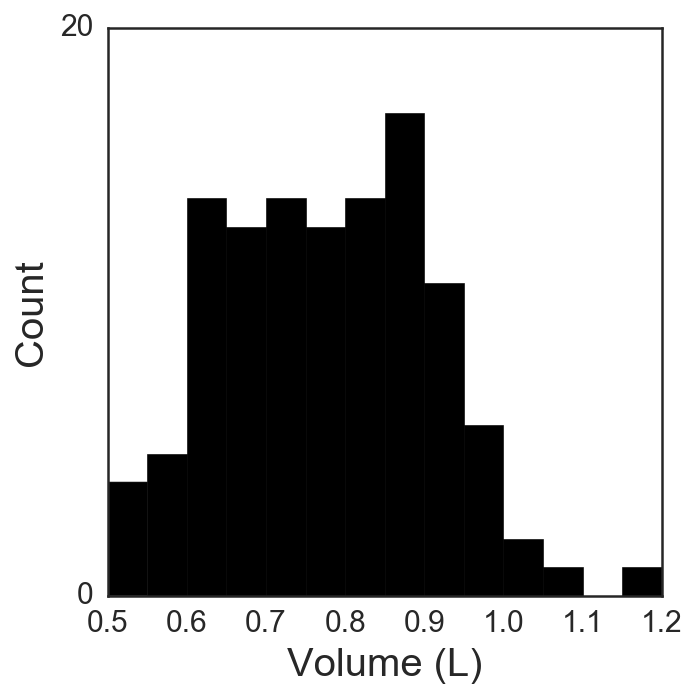

In [8]:
# Volume dist
plt.figure(figsize=(5,5))
n, _, _ = plt.hist(df.Volume.dropna(),np.arange(0.5,1.3,.05),color='k')
plt.xlabel('Volume (L)',size=20)
plt.xticks(np.arange(0.5,1.3,.1),size=15)
plt.xlim((0.5,1.2))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'volumedist'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

print np.mean(df.Volume)

In [9]:
def metrichist(metricname):
    plt.figure(figsize=(5,5))
    n, _, _ = plt.hist(df[metricname].dropna(),np.arange(-.25,5.5,.5),color='k')
    plt.xlabel(metricname + ' rating',size=20)
    plt.xticks(np.arange(0,5.5,.5),size=15)
    plt.xlim((-.25,5.25))
    plt.ylabel('Count',size=20)
    plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
    plt.tight_layout()
    
    if metricname == 'Meat:filling':
        metricname = 'meattofilling'
    figname = metricname + 'dist'
    plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

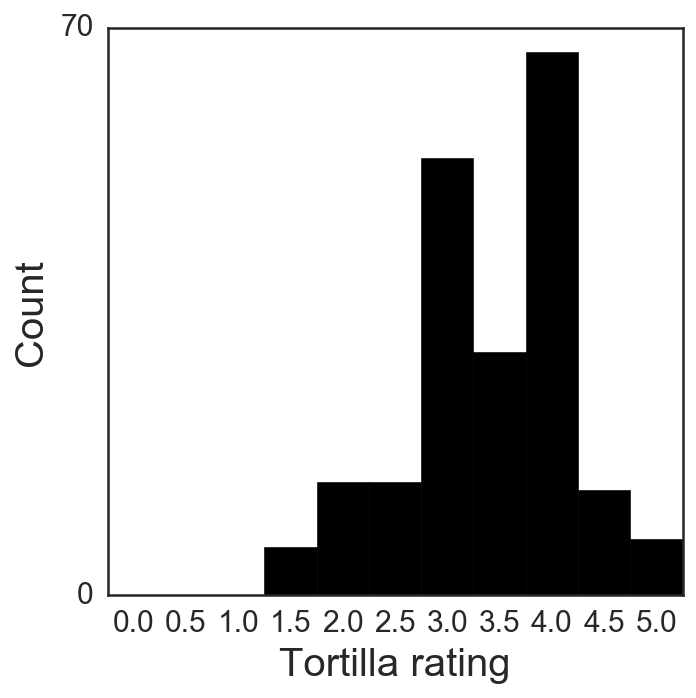

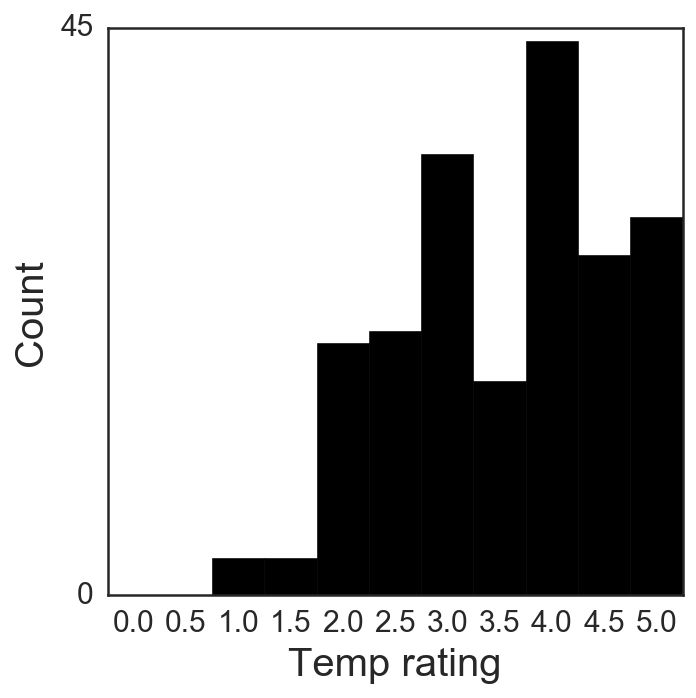

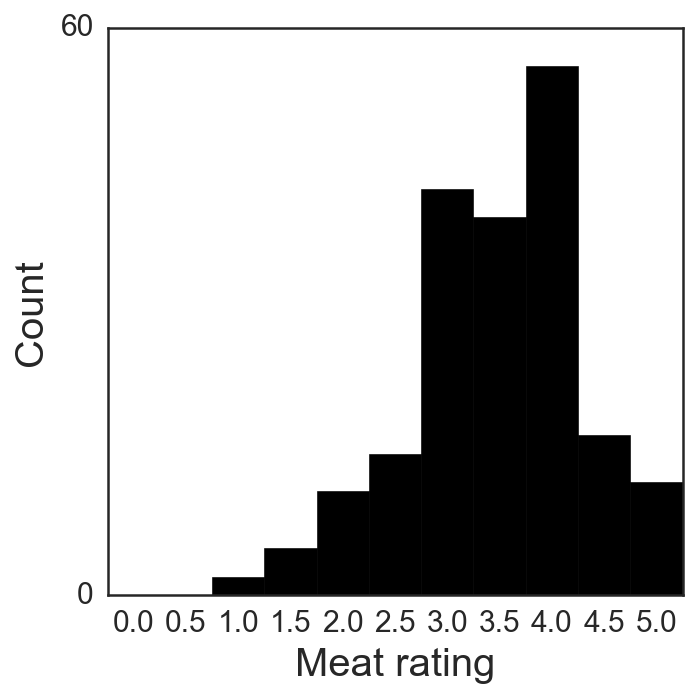

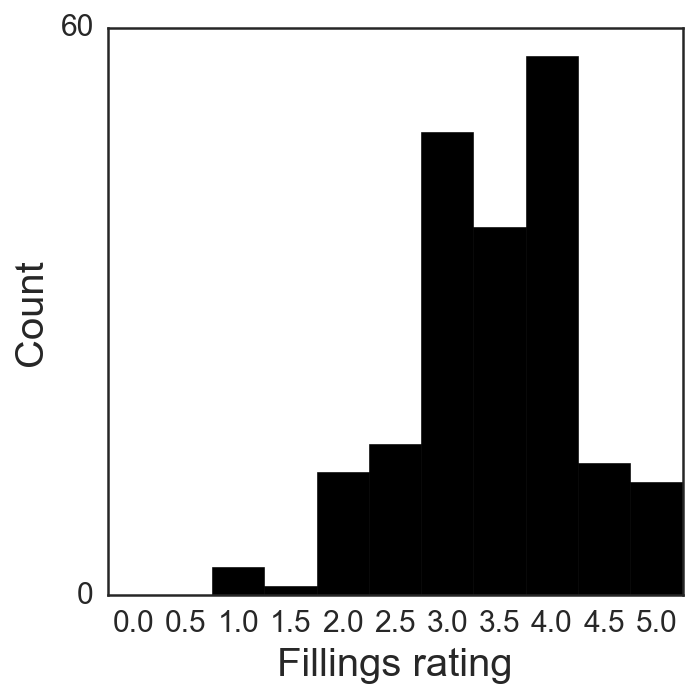

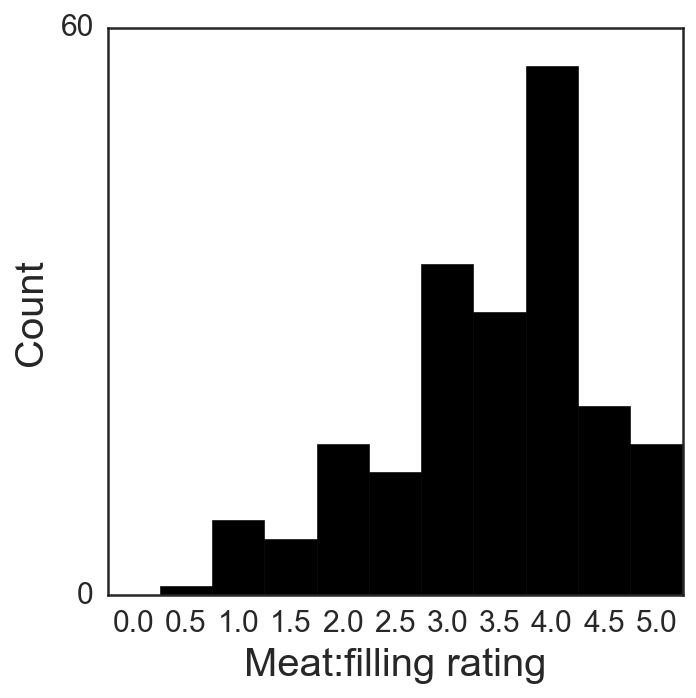

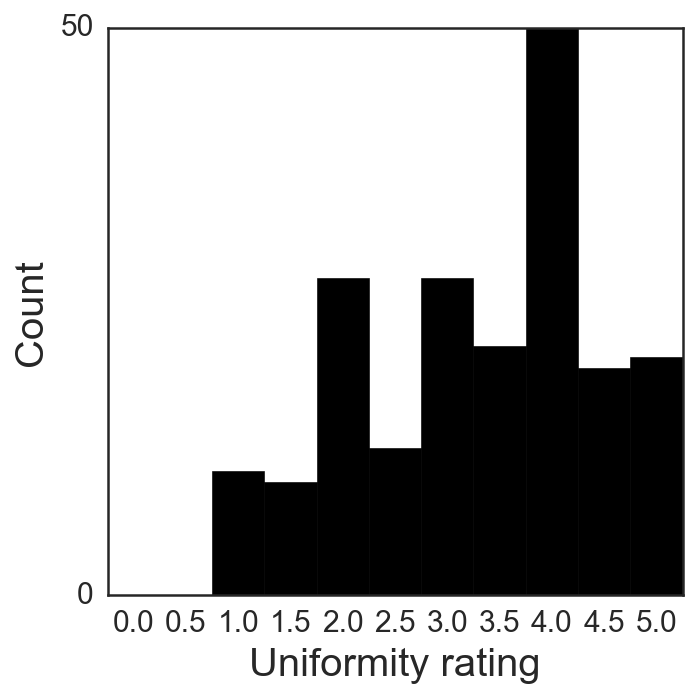

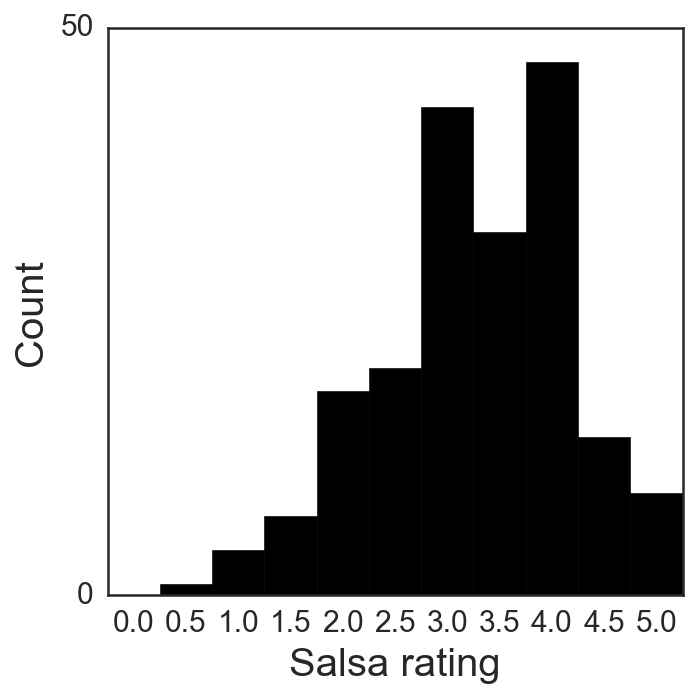

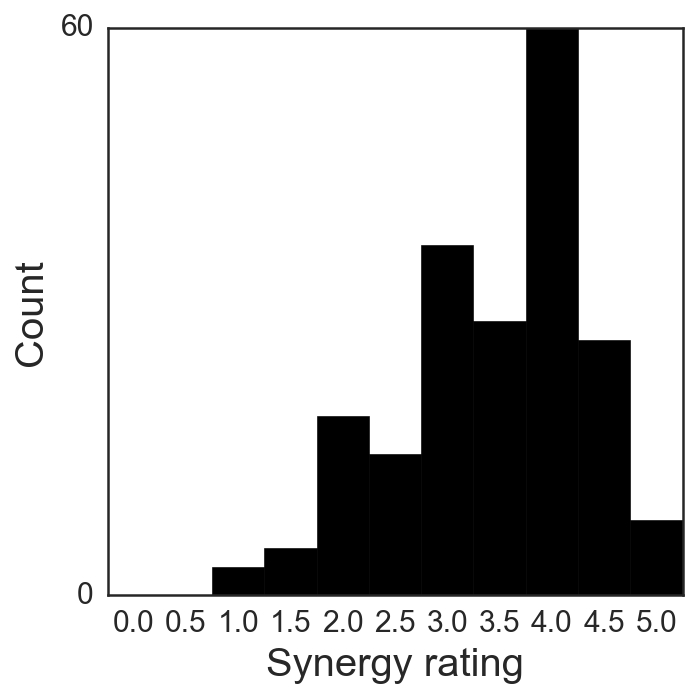

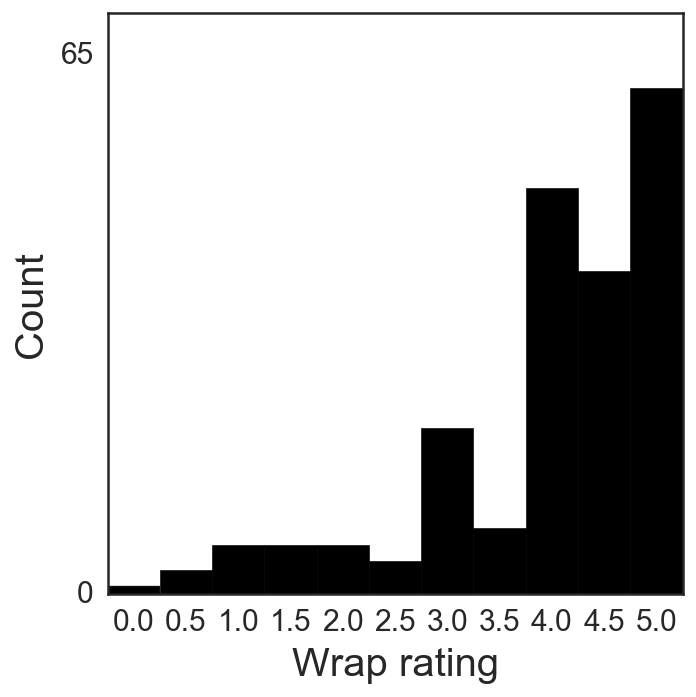

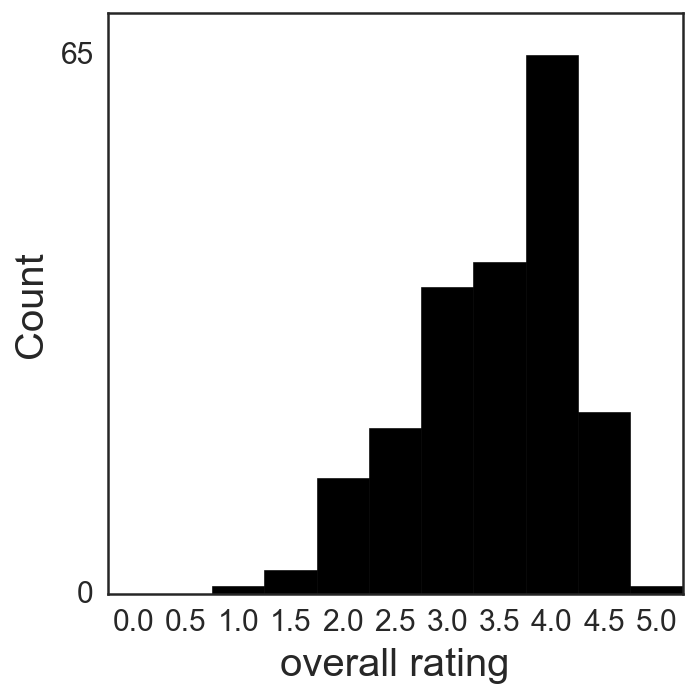

In [10]:
m_Hist = ['Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Synergy','Wrap','overall']
for m in m_Hist:
    metrichist(m)

# Fraction of burritos recommended

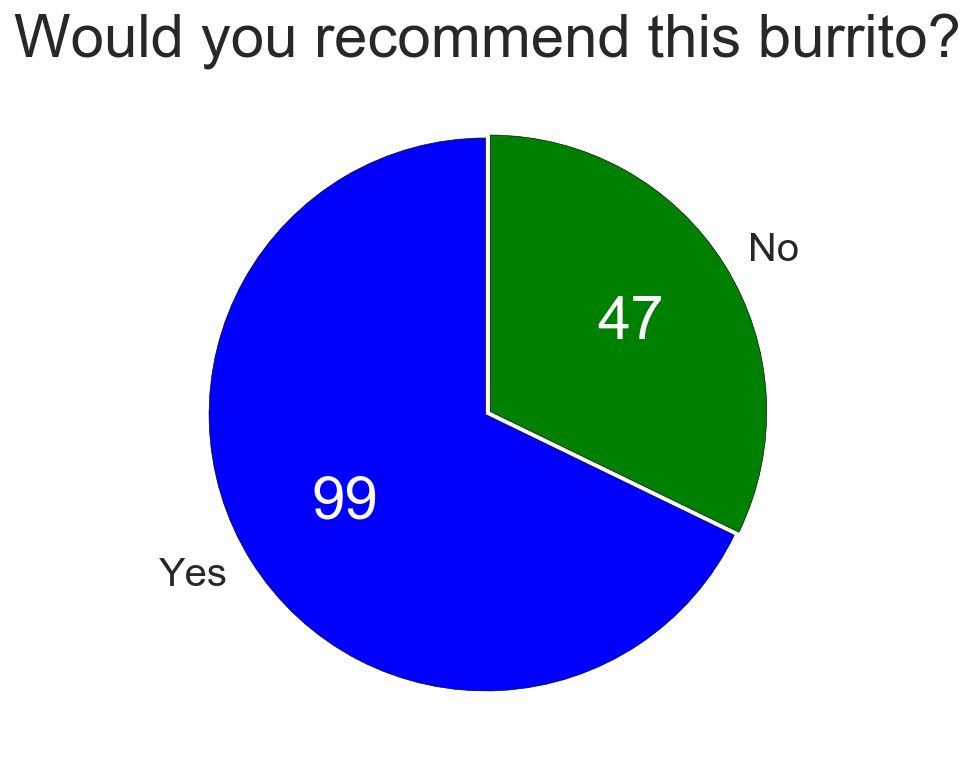

In [11]:
# Overall recommendations
plt.figure(figsize=(6,6))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

# The slices will be ordered and plotted counter-clockwise.
labels = ['Yes','No']
fracs = np.array([np.sum(df.Rec==labels[0]),np.sum(df.Rec==labels[1])])
explode=[.01]*len(labels)

patches, texts, autotexts = plt.pie(fracs, explode=explode, labels=labels,
                autopct=lambda(p): '{:.0f}'.format(p * np.sum(fracs) / 100), shadow=False, startangle=90)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

plt.title('Would you recommend this burrito?',size=30)
for t in texts:
    t.set_size(20)
for t in autotexts:
    t.set_size(30)
autotexts[0].set_color('w')
autotexts[1].set_color('w')

figname = 'recspie'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

# PCA

In [12]:
dfpca = df[['Volume','Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Synergy','Wrap']]

In [13]:
dfpca = dfpca.fillna(dfpca.mean())

In [14]:
# Normalize
dfpca = (dfpca - dfpca.mean()) / dfpca.std()
dfpca

,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,-5.733812e-15,-0.524920,1.414522,-5.681489e-01,0.058386,5.814573e-01,0.612077,8.046336e-01,0.617624,0.038994
1,-5.733812e-15,-1.796136,-0.058427,-1.169824e+00,-1.163234,-1.396925e+00,0.612077,2.548664e-01,-1.052594,0.908862
2,-5.733812e-15,-0.524920,-1.531375,-1.169824e+00,-0.552424,1.076053e+00,0.612077,-2.949008e-01,-0.495855,0.908862
3,-5.733812e-15,-0.524920,-1.531375,3.352617e-02,-0.552424,5.814573e-01,1.492670,8.046336e-01,0.617624,0.908862
4,-5.733812e-15,0.746297,1.414522,6.352012e-01,0.058386,1.076053e+00,1.492670,-8.446679e-01,1.174363,0.038994
5,-5.733812e-15,-0.524920,0.432556,1.838551e+00,0.058386,-9.023292e-01,-0.708812,-8.446679e-01,0.617624,-2.570611
6,-5.733812e-15,-1.796136,-0.549410,-5.681489e-01,-1.774045,-9.023292e-01,-0.708812,-4.882913e-16,-1.609333,-0.830874
7,-5.733812e-15,-1.160528,-0.549410,-5.681489e-01,-1.163234,-4.077337e-01,0.171781,-4.882913e-16,-1.052594,-0.830874
8,-5.733812e-15,-1.796136,0.923539,1.236876e+00,0.058386,-1.891520e+00,-0.268516,2.548664e-01,0.617624,-1.700742
9,-5.733812e-15,-1.160528,-2.022358,-2.373174e+00,-0.552424,1.076053e+00,-0.268516,-1.944202e+00,-1.609333,0.473928


In [15]:
# Color: Taco Stand, Lucha, Los Primos

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(dfpca)
print pca.components_
print pca.explained_variance_ratio_

[[ 0.09140323  0.34910053  0.17898987  0.38747809  0.40925954  0.34447879
   0.29984814  0.29372121  0.45398805  0.13839222]
 [ 0.51858664 -0.03497348 -0.44209335  0.21269247  0.26105376 -0.30758935
  -0.28310262  0.13957521  0.14797087 -0.45263248]]
[ 0.32197444  0.1244766 ]


In [17]:
np.sum(pca.components_,1)

array([ 2.94665968, -0.24051234])

In [18]:
dfpca_proj = np.dot(pca.components_,dfpca.T)

In [19]:
np.sum(df.Location=='taco stand')

19

In [20]:
foo = 'abc'
bar = 'ba'
zoo = '123'
foo == 'abc' and bar == 'bac' or zoo == '123'

True

In [21]:
dfpca_proj[0][np.where(df.Location=='taco stand')]

array([ 0.89426587,  2.06758488,  1.46777096,  1.05971135,  2.09929611,
        0.66377575,  1.01605783,  0.81360995,  3.86515497,  1.18784127,
        2.87047131,  0.47144678,  1.16722648,  2.33019341,  0.76804706,
        1.13819505,  0.37502151,  1.08393512,  0.84239059])

In [22]:
shops[0] is 

SyntaxError: invalid syntax (<ipython-input-22-69c2e504f810>, line 1)

In [ ]:
np.sum(np.logical_or(notshops,df.Location==shops[2]))

In [ ]:
plt.plot(dfpca_proj[0],dfpca_proj[1],'k.')

In [ ]:
plt.figure(figsize=(8,8))
shops = ['taco stand','lucha libre north park','los primos mexican food']
shops_marker = ['*','^','s']
shops_ms = [20,12,12]
overallcutoffs = [-.1, 3, 4, 5.1]
overallcolors = ['r','k','g']


for o in range(len(overallcolors)):
    notshops = np.logical_and(df.Location != shops[0],np.logical_and(df.Location != shops[1],df.Location != shops[2]))
    orange = np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])
    notshops = np.where(np.logical_and(notshops,orange))
    plt.plot(dfpca_proj[0][notshops],dfpca_proj[1][notshops],'.',color=overallcolors[o],alpha=.5,ms=20)
    for s in range(len(shops)):
        burridx = np.where(np.logical_and(df.Location==shops[s],np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])))
        plt.plot(dfpca_proj[0][burridx],dfpca_proj[1][burridx],
                 shops_marker[s],color=overallcolors[o],ms=shops_ms[s],label = shops[s])
plt.xlim((-8,4.5))
plt.ylim((-3,4))
plt.xlabel('PC 1',size=20)
plt.ylabel('PC 2',size=20)
plt.xticks([])
plt.yticks([])
plt.legend(loc='best')

In [ ]:
shopsalpha = [.2,.2,.2]
shops = ['taco stand','lucha libre north park','los primos mexican food']
overall_marker = ['v','.','*']
overall_ms = [12,25,20]
overallcutoffs = [-.1, 3, 4, 5.1]
shopscolors = ['g','b','r']

plt.figure(figsize=(8,8))
for o in range(len(overallcolors)):
    notshops = np.logical_and(df.Location != shops[0],np.logical_and(df.Location != shops[1],df.Location != shops[2]))
    orange = np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])
    notshops = np.where(np.logical_and(notshops,orange))[0]
    #plt.plot(df.Meat[notshops],df.Fillings[notshops],'.',color=overallcolors[o],alpha=.2,ms=20)
    for s in range(len(shops)):
        burridx = np.where(np.logical_and(df.Location==shops[s],np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])))[0]
        plt.plot(df.Meat[burridx],df.Salsa[burridx],
                 overall_marker[o],color=shopscolors[s],ms=overall_ms[o],alpha=shopsalpha[s],label=shops[s])
plt.xlim((0,5.5))
plt.ylim((0,5.5))
plt.xlabel('Meat flavor',size=20)
plt.ylabel('Salsa flavor',size=20)
plt.xticks(np.arange(1,6),size=20)
plt.yticks(np.arange(1,6),size=20)
plt.legend(loc='best',fontsize=12)

plt.savefig('C:/gh/fig/burrito/superscatter.png')

In [ ]:
np.shape(dfpca_proj)

In [ ]:
x_pca = np.dot(pca.components_,x_orig)

In [ ]:
print np.dot(pca.components_.T,x_pca)

In [ ]:
print x_orig

In [ ]:
print pca.components_[0]

In [ ]:
np.sum(pca.components_[0]**2)

In [ ]:
pca.components_*pca.components_.T

In [ ]:
pca.explained_variance_ratio_

In [ ]:
x_orig = dfpca.loc[0]
x_orig2 = np.dot(x_orig)

In [ ]:
np.dot(pca.components_[0],